In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import uuid #to generate random id
import pickle #to save/load list of selected hens
import cv2

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr, spearmanr 
import scipy.stats as stats

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for barplot
from mpl_toolkits.mplot3d import Axes3D

#network
import networkx as nx

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import chi2_distance, ts_visual, time_series_henColumn_tsRow, correct_key, FB_daily, FB_process_hen
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_dataoutput = config.path_dataoutput
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_final_'
#path_dataoutput = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput'
#path_extracted_data = os.path.join(path_dataoutput,'TrackingSystem') 
#path_extracted_data = os.path.join(path_extracted_data, id_run)
dico_night_hour = config.dico_night_hour
dico_matching = config.dico_matching
path_extracted_HA = config.path_extracted_HA
path_extracted_HA_visual = config.path_extracted_HA_visual
id_run_KBF = 'all'
path_saveIMAGE = os.path.join(path_extracted_HA, 'AllPicturesKBF_'+id_run_KBF)
#create a director if not existing
if not os.path.exists(path_extracted_HA_visual):
    os.makedirs(path_extracted_HA_visual)
print(id_run)

change the configuration file if not done yet!
EXP2_


# Download variables

In [4]:
#KBF&severity
df_HA = pd.read_csv(os.path.join(r'G:\VPHI\Welfare\2- Research Projects\Camille Montalcini\Origins.GS\FOCAL BIRDS', 
                                 'Focalbirds_12-07-2022.csv'), sep=',', encoding='latin') 
print(df_HA.shape)
df_HA.head(3)

(169, 47)


,HenID,SireID,RPenID,PenID,Rtreatment,LPLegring,legringID,FocalLegringName,HA1_weight,HA1_NeckFeather,...,HA3_weight,HA3_NeckFeather,HA3_BreastFeather,HA3_TailFeather,comment HA3 12-04-2022,HA4_weight,HA4_NeckFeather,HA4_BreastFeather,HA4_TailFeather,comment HA4 05-07-2022
0,113,37,Rpen14,pen5,NoQueue,black,1,black1,1623.3,100,...,1730.4,100,65,80,NaN,1771.1,100.0,80.0,71.0,NaN
1,91,13,Rpen13,pen4,NoQueue,brightgreen,1,brightgreen1,1768.6,100,...,1785.4,100,43,71,NaN,1864.4,55.0,28.0,30.0,NaN
2,144,37,Rpen13,pen8,NoQueue,darkblue,1,darkblue1,1680.6,100,...,1809.9,92,100,81,NaN,1786.7,77.0,80.0,59.0,NaN


In [5]:
#keel bone fractures
df_KBF = pd.read_csv(os.path.join(path_extracted_HA, path_saveIMAGE,'DF_IMAGE_INFO_comma_rated.csv'), sep=',')
#remove when it was not a radiographs that worked (i.e. when we let it empty)
df_KBF = df_KBF[~df_KBF['HenIDKBF'].isnull()]
df_KBF['HenIDKBF'] = df_KBF['HenIDKBF'].map(lambda x: x[3:] if x.lower().startswith('pen') else x) #for simplicity
#ensure all green are relaced by brightgreen without brightgreen beeing replace by brightbrightgreen
df_KBF['HenIDKBF'] = df_KBF['HenIDKBF'].map(lambda x: x.replace('brightgreen','green').replace('green','brightgreen').replace('daarkblue','darkblue'))
#as in first experiemnt, make it from 0-100
df_KBF['severity'] = df_KBF['severity'].map(lambda x: int(x*10*2))
print(df_KBF['severity'].min())
print(df_KBF['severity'].max())
print(df_KBF.shape)
df_KBF.head(3)

0
84
(699, 9)


,initial_path_img,actual_path_img,imageID,HAID,random_order1,HenIDKBF,has_gap,severity,comment
0,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,0,HA2,330,12pink58,0.0,12,NaN
1,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,1,HA3,77,10red49,1.0,48,NaN
2,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,2,HA1,50,lightblue39,0.0,0,NaN


# Add HenID to KBF file

In [6]:
#check if we can already do manually what would then need to be done manually
#df_KBF[(df_KBF['HAID']=='HA4')&(~df_KBF['PenID'].isin([3,5,8,9,10,11,12]))][['PenID','HenIDKBF','TagID','HenID']]
df_KBF['todomanually'] = df_KBF['HenIDKBF'].map(lambda x: '?' in x)
df_KBF[df_KBF['todomanually']]

,initial_path_img,actual_path_img,imageID,HAID,random_order1,HenIDKBF,has_gap,severity,comment,todomanually


In [7]:
#color of the laying pen legring
li_LPlegring = list(df_HA['LPLegring'].unique())
df_KBF['LPLegring'] = df_KBF['HenIDKBF'].map(lambda x: [i for i in li_LPlegring if i in x])
df_KBF['LPLegring'] = df_KBF['LPLegring'].map(lambda x: x[0] if len(x)==1 else 'unknown')
display(df_KBF[df_KBF['LPLegring']=='unknown'])
display(df_KBF['LPLegring'].value_counts())
df_KBF.head(3)

,initial_path_img,actual_path_img,imageID,HAID,random_order1,HenIDKBF,has_gap,severity,comment,todomanually,LPLegring
37,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,37,HA4,434,4tagid201,0.0,32,was: pen4tagid20?,False,unknown
53,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,53,HA4,719,4tagid214b,0.0,20,NaN,False,unknown
89,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,89,HA4,656,10tagid16,0.0,30,was pen10tagid16?,False,unknown
94,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,94,HA4,323,12tagid107,1.0,24,NaN,False,unknown
193,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,193,HA4,464,11tagid114,1.0,50,NaN,False,unknown
208,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,208,HA4,94,5tagid145,0.0,16,NaN,False,unknown
226,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,226,HA4,363,10tagid215,0.0,16,was pen10tagid21?,False,unknown
376,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,376,HA4,640,4tagid44,1.0,70,NaN,False,unknown
391,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,391,HA4,636,4tagid188,0.0,36,NaN,False,unknown
420,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,420,HA4,733,8tagid208,0.0,24,NaN,False,unknown


black          88
brightgreen    87
red            85
lightblue      85
darkblue       85
yellow         85
violette       84
pink           77
unknown        23
Name: LPLegring, dtype: int64

,initial_path_img,actual_path_img,imageID,HAID,random_order1,HenIDKBF,has_gap,severity,comment,todomanually,LPLegring
0,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,0,HA2,330,12pink58,0.0,12,NaN,False,pink
1,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,1,HA3,77,10red49,1.0,48,NaN,False,red
2,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,2,HA1,50,lightblue39,0.0,0,NaN,False,lightblue


In [8]:
#TagID
df_KBF['TagID'] = df_KBF['HenIDKBF'].map(lambda x:  x.lower().split('tagid') if '?' not in x else '')
df_KBF['TagID'] = df_KBF['TagID'].map(lambda x:  x[1] if len(x)>=2 else '')
#small example
re.findall(r'\d+', '196pink3') #['196', '3']
df_KBF['TagID'] = df_KBF['TagID'].map(lambda x:  int(re.findall(r'\d+', x)[0]) if len(re.findall(r'\d+', x))>0 else np.nan) #first nbr after the tagID
df_KBF.head(3)

,initial_path_img,actual_path_img,imageID,HAID,random_order1,HenIDKBF,has_gap,severity,comment,todomanually,LPLegring,TagID
0,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,0,HA2,330,12pink58,0.0,12,NaN,False,pink,NaN
1,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,1,HA3,77,10red49,1.0,48,NaN,False,red,NaN
2,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,2,HA1,50,lightblue39,0.0,0,NaN,False,lightblue,NaN


In [9]:
#legringID (remve first two to ensure no penid are shown) and find out FocalLegringName
df_KBF['legringID'] = df_KBF['HenIDKBF'].map(lambda x: int(re.findall(r'\d+', x[2:])[0]) if ((len(re.findall(r'\d+', x[2:]))>0)&('tagid' not in x.lower())) else np.nan)

df_KBF['FocalLegringName'] = df_KBF.apply(lambda x: x['LPLegring']+str(int(x['legringID'])) if ((x['LPLegring']!='unknown')&\
                                                                                    (math.isnan(x['legringID'])==False)) else '', axis=1)

In [10]:
#PenID
df_KBF['PenID'] = df_KBF['HenIDKBF'].map(lambda x: int(re.findall(r'\d+', x[0:2])[0]) if len(re.findall(r'\d+', x[0:2]))>0 else np.nan)
df_KBF['PenID'].value_counts()

4.0     65
10.0    64
9.0     62
3.0     62
8.0     62
5.0     61
11.0    61
12.0    56
Name: PenID, dtype: int64

In [11]:
#random animals and save it in another dataframe
df_KBF['randomanimals'] = df_KBF['HenIDKBF'].map(lambda x: x.startswith('R'))
display(df_KBF[df_KBF['randomanimals']][['HAID','HenIDKBF']])
df_RKBF = df_KBF[df_KBF['randomanimals']].copy()
df_KBF = df_KBF[~df_KBF['randomanimals']]

,HAID,HenIDKBF
8,HA4,Rpen10red24
22,HA4,Rpen5black70
42,HA4,Rpen8darkblue3
45,HA4,Rpen12pink60
71,HA4,Rpen9violette19
91,HA4,Rpen11lightblue56
150,HA4,Rpen12pink2
157,HA4,Rpen12pink12
261,HA4,Rpen5black14
269,HA4,Rpen4brightgreen72


In [12]:
#finally join HenID to the df_KBF by tagid else by focallegringname
#unique combination
dico_tagid_henID = dict(zip(df_HA['TagID'], df_HA['HenID']))
dico_FocalLegringName_henID = dict(zip(df_HA['FocalLegringName'], df_HA['HenID']))
df_KBF['HenID'] = df_KBF.apply(lambda x: dico_tagid_henID[x['TagID']] if x['TagID'] in dico_tagid_henID.keys() else dico_FocalLegringName_henID.get(x['FocalLegringName'], ''), axis=1)
display(df_KBF['HenID'].value_counts())
df_KBF[df_KBF['HenID']=='']

46     4
30     4
147    4
167    4
19     4
      ..
3      3
52     3
67     3
110    3
166    3
Name: HenID, Length: 170, dtype: int64

,initial_path_img,actual_path_img,imageID,HAID,random_order1,HenIDKBF,has_gap,severity,comment,todomanually,LPLegring,TagID,legringID,FocalLegringName,PenID,randomanimals,HenID
49,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,49,HA1,408,black4,0.0,0,NaN,False,black,NaN,4.0,black4,NaN,False,
108,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,108,HA1,326,darkblue5,1.0,40,NaN,False,darkblue,NaN,5.0,darkblue5,NaN,False,
230,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,230,HA1,362,black23,0.0,0,NaN,False,black,NaN,23.0,black23,NaN,False,
491,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,491,HA4,176,8darkblue5,1.0,40,NaN,False,darkblue,NaN,5.0,darkblue5,8.0,False,


In [13]:
#unique combination
dico_tagid_henID = dict(zip(df_HA['TagID'], df_HA['HenID']))
dico_FocalLegringName_henID = dict(zip(df_HA['FocalLegringName'], df_HA['HenID']))
df_KBF['HenID'] = df_KBF.apply(lambda x: dico_tagid_henID[x['TagID']] if x['TagID'] in dico_tagid_henID.keys() else dico_FocalLegringName_henID.get(x['FocalLegringName'], ''), axis=1)
display(df_KBF['HenID'].value_counts())
df_KBF[df_KBF['HenID']==''][['PenID','HenID','imageID','FocalLegringName','HenIDKBF','HAID']]
#8darkblue5 HA4 no idea

46     4
30     4
147    4
167    4
19     4
      ..
3      3
52     3
67     3
110    3
166    3
Name: HenID, Length: 170, dtype: int64

,PenID,HenID,imageID,FocalLegringName,HenIDKBF,HAID
49,NaN,,49,black4,black4,HA1
108,NaN,,108,darkblue5,darkblue5,HA1
230,NaN,,230,black23,black23,HA1
491,8.0,,491,darkblue5,8darkblue5,HA4


# join KBF and HA

In [14]:
#HA1: try to solv emissing hens
df_HA['HA1_severity_'] = df_HA['HenID'].map(lambda x: df_KBF[(df_KBF['HAID']=='HA1')&(df_KBF['HenID']==x)]['severity'].values)
df_HA['HA1_severity'] = df_HA['HA1_severity_'].map(lambda x: x[0] if len(x)==1 else np.nan)
df_HA['HA1_has_gap_'] = df_HA['HenID'].map(lambda x: df_KBF[(df_KBF['HAID']=='HA1')&(df_KBF['HenID']==x)]['has_gap'].values)
df_HA['HA1_has_gap'] = df_HA['HA1_has_gap_'].map(lambda x: x[0] if len(x)==1 else np.nan)
df_HA[df_HA['HA1_severity'].isnull()][['PenID','HenID','HA1_severity_','HA1_severity','TagID','FocalLegringName','HA1_weight','HA1_has_gap']]
#cant find these hens althought the vet a cocher la case in the sheet... probably she just forgot it

,PenID,HenID,HA1_severity_,HA1_severity,TagID,FocalLegringName,HA1_weight,HA1_has_gap
30,pen9,157,[],NaN,133,violette8,1709.3,NaN
42,pen3,67,[],NaN,57,yellow10,1636.7,NaN


In [15]:
#HA2: try to solv emissing hens
df_HA['HA2_severity_'] = df_HA['HenID'].map(lambda x: df_KBF[(df_KBF['HAID']=='HA2')&(df_KBF['HenID']==x)]['severity'].values)
df_HA['HA2_severity'] = df_HA['HA2_severity_'].map(lambda x: x[0] if len(x)==1 else np.nan)
df_HA['HA2_has_gap_'] = df_HA['HenID'].map(lambda x: df_KBF[(df_KBF['HAID']=='HA2')&(df_KBF['HenID']==x)]['has_gap'].values)
df_HA['HA2_has_gap'] = df_HA['HA2_has_gap_'].map(lambda x: x[0] if len(x)==1 else np.nan)
display(df_HA[df_HA['HA2_severity'].isnull()][['R1','HenID','HA2_severity_','HA2_severity','TagID','FocalLegringName','HA2_weight']])
#yellow8: vet said she did not saw it
#violette14: vet said she did not saw it
#black22: cant find it, the vet noted that she used the tagid(145)
#black25: the vet noted she did not saw it
#we will not use both now and leave it as is (np.nan)
#pink28: vet said she saw is, but no images, probably forgot to do it

,R1,HenID,HA2_severity_,HA2_severity,TagID,FocalLegringName,HA2_weight
31,pen9,72,[],NaN,93,yellow8,2091.7
60,pen11,166,[],NaN,179,violette14,1722.8
100,pen5,119,[],NaN,145,black22,1765.2
115,pen5,110,[],NaN,94,black25,1864.6
125,pen12,52,[],NaN,158,pink28,1873.1


In [16]:
#HA3: try to solve missing hens
df_HA['HA3_severity_'] = df_HA['HenID'].map(lambda x: df_KBF[(df_KBF['HAID']=='HA3')&(df_KBF['HenID']==x)]['severity'].values)
df_HA['HA3_severity'] = df_HA['HA3_severity_'].map(lambda x: x[0] if len(x)==1 else np.nan)
df_HA['HA3_has_gap_'] = df_HA['HenID'].map(lambda x: df_KBF[(df_KBF['HAID']=='HA3')&(df_KBF['HenID']==x)]['has_gap'].values)
df_HA['HA3_has_gap'] = df_HA['HA3_has_gap_'].map(lambda x: x[0] if len(x)==1 else np.nan)

display(df_HA[df_HA['HA3_severity'].isnull()][['R2','HenID','HA3_severity_','HA3_severity','TagID','FocalLegringName','HA3_weight']])

,R2,HenID,HA3_severity_,HA3_severity,TagID,FocalLegringName,HA3_weight


In [17]:
#HA4: try to solve missing hens
df_HA['HA4_severity_'] = df_HA['HenID'].map(lambda x: df_KBF[(df_KBF['HAID']=='HA4')&(df_KBF['HenID']==x)]['severity'].values)
df_HA['HA4_severity'] = df_HA['HA4_severity_'].map(lambda x: x[0] if len(x)==1 else np.nan)
df_HA['HA4_has_gap_'] = df_HA['HenID'].map(lambda x: df_KBF[(df_KBF['HAID']=='HA4')&(df_KBF['HenID']==x)]['has_gap'].values)
df_HA['HA4_has_gap'] = df_HA['HA4_has_gap_'].map(lambda x: x[0] if len(x)==1 else np.nan)
display(df_HA[(df_HA['HA4_severity'].isnull())&(~df_HA['HA4_weight'].isnull())][['R3','HenID','HA4_severity_','HA4_severity','TagID','FocalLegringName','HA4_weight']])
#because brightgreen10 ; red15 ; violette18 ; pink30 : all died so we added ~df_HA['HA4_weight'].isnull() to make it clearer (the one taht died did not have the weight, the weight were already checked)
#brightgreen12: cant know which one it is, we simple wont use both and leave it as is: np.nan

,R3,HenID,HA4_severity_,HA4_severity,TagID,FocalLegringName,HA4_weight


In [18]:
#used to check stuff
#display(df_KBF[(df_KBF['HenID']==84)&(df_KBF['HAID']=='HA4')])
#df_KBF[(df_KBF['HenID']==38)&(df_KBF['HAID']=='HA4')]['initial_path_img'].tolist()
#df_KBF[(df_KBF['HAID']=='HA2')&(~df_KBF['PenID'].isin([3,4,8,9,10,11,12]))][['PenID','HenIDKBF','TagID','HenID']]

# Focal vs non-focal

In [19]:
#non focal (boxplot does not make sence for 4 points, lets jsut see it visually)
df_RKBF['PenID'] = df_RKBF['HenIDKBF'].map(lambda x: int(re.findall(r'\d+', x)[0]))
df_r = df_RKBF.groupby(['PenID'])['severity'].agg(lambda x: list(x)).reset_index()
df_r['mean'] = df_r['severity'].map(lambda x: np.mean(x))
df_r['median'] = df_r['severity'].map(lambda x: np.median(x))
display(df_r)
df_RKBF['severity'].mean()

,PenID,severity,mean,median
0,3,"[30, 44, 20, 26]",30.0,28.0
1,4,"[8, 14, 26]",16.0,14.0
2,5,"[64, 32, 38, 56]",47.5,47.0
3,8,"[12, 60, 18]",30.0,18.0
4,9,"[46, 38, 32, 46]",40.5,42.0
5,10,"[14, 0, 66, 36]",29.0,25.0
6,11,"[38, 12, 36, 44]",32.5,37.0
7,12,"[26, 2, 4, 32]",16.0,15.0


30.666666666666668

In [20]:
#focal
df_r = df_KBF[df_KBF['HAID']=='HA4'].groupby(['PenID'])['severity'].agg(lambda x: list(x)).reset_index()
df_r['mean'] = df_r['severity'].map(lambda x: np.mean(x))
df_r['median'] = df_r['severity'].map(lambda x: np.median(x))
display(df_r)
df_KBF['severity'].mean()

,PenID,severity,mean,median
0,3.0,"[20, 12, 14, 12, 10, 42, 40, 12, 66, 22, 58, 5...",23.904762,14.0
1,4.0,"[32, 20, 18, 36, 60, 38, 52, 36, 74, 4, 52, 70...",39.545455,36.0
2,5.0,"[36, 16, 34, 28, 40, 34, 64, 18, 30, 4, 10, 24...",34.095238,34.0
3,8.0,"[10, 16, 28, 32, 48, 64, 38, 52, 38, 80, 24, 4...",38.095238,38.0
4,9.0,"[32, 36, 70, 34, 26, 36, 28, 62, 62, 12, 28, 3...",33.428571,34.0
5,10.0,"[58, 62, 30, 52, 10, 2, 16, 34, 32, 50, 4, 58,...",35.333333,32.0
6,11.0,"[14, 56, 40, 28, 50, 8, 40, 10, 32, 46, 50, 36...",35.363636,34.0
7,12.0,"[10, 10, 24, 56, 34, 20, 64, 32, 46, 58, 36, 3...",37.647059,36.0


20.194319880418536

# Join feathers as in experiment 1

In [21]:
# Join feathers as in experiment 1
for i in range(1,5):
    df_HA['HA'+str(i)+'_Feather'] = df_HA.apply(lambda x: np.mean([x['HA'+str(i)+'_BreastFeather'],x['HA'+str(i)+'_TailFeather'],x['HA'+str(i)+'_NeckFeather']]),axis=1)
df_HA.head(3)                            

,HenID,SireID,RPenID,PenID,Rtreatment,LPLegring,legringID,FocalLegringName,HA1_weight,HA1_NeckFeather,...,HA3_has_gap_,HA3_has_gap,HA4_severity_,HA4_severity,HA4_has_gap_,HA4_has_gap,HA1_Feather,HA2_Feather,HA3_Feather,HA4_Feather
0,113,37,Rpen14,pen5,NoQueue,black,1,black1,1623.3,100,...,[0.0],0.0,[14],14.0,[0.0],0.0,100.0,99.333333,81.666667,83.666667
1,91,13,Rpen13,pen4,NoQueue,brightgreen,1,brightgreen1,1768.6,100,...,[0.0],0.0,[56],56.0,[1.0],1.0,100.0,67.000000,71.333333,37.666667
2,144,37,Rpen13,pen8,NoQueue,darkblue,1,darkblue1,1680.6,100,...,[1.0],1.0,[28],28.0,[0.0],0.0,100.0,91.000000,91.000000,72.000000


# Visual KBF over time

,HenID,PenID,variable,severity
0,113,pen5,HA1_severity,0.0
1,91,pen4,HA1_severity,0.0
2,144,pen8,HA1_severity,0.0


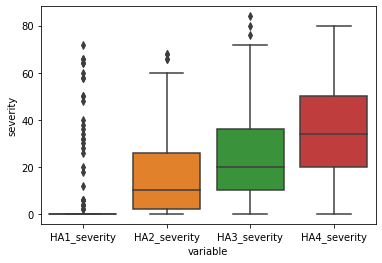

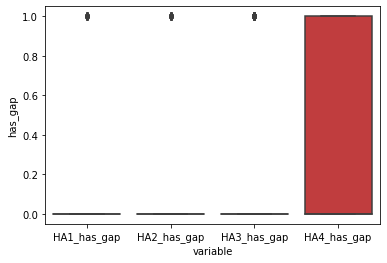

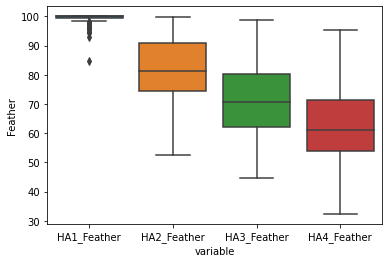

In [22]:
#population level
df_plt = pd.melt(df_HA, id_vars=['HenID','PenID'], value_vars=['HA1_severity','HA2_severity','HA3_severity','HA4_severity'], 
                 value_name = 'severity')
display(df_plt.head(3))
sns.boxplot(x='variable',y='severity', data=df_plt);
plt.show()

df_plt = pd.melt(df_HA, id_vars=['HenID','PenID'], value_vars=['HA1_has_gap','HA2_has_gap','HA3_has_gap','HA4_has_gap'], 
                 value_name = 'has_gap')
sns.boxplot(x='variable',y='has_gap', data=df_plt);
plt.show()

df_plt = pd.melt(df_HA, id_vars=['HenID','PenID'], value_vars=['HA1_Feather','HA2_Feather','HA3_Feather','HA4_Feather'], 
                 value_name = 'Feather')
sns.boxplot(x='variable',y='Feather', data=df_plt);

In [23]:
#individual level
df_plot = df_KBF.sort_values('HAID').copy()
df_plot = df_plot[~df_plot['actual_path_img'].isnull()] #missing KBF
df_plot = df_plot.groupby(['HenID'])[['HAID','actual_path_img','severity','has_gap']].agg(lambda x: list(x)).reset_index()
for i in tqdm.tqdm(range(df_plot.shape[0])):
    x = df_plot.iloc[i]
    li_path = x['actual_path_img']
    li_HAID = x['HAID']
    henid = x['HenID']
    li_sev = x['severity']
    li_gap = x['has_gap']
    c = len(li_path) ; l = 1
    fig = plt.figure(figsize=(c*3, l*3)) #/100 si trop grand nbr
    for i,path_ in enumerate(li_path):
        plt.subplot(l,c,i+1)
        plt.tight_layout() #avoid titles superpositions
        img = cv2.imread(path_)
        plt.imshow(img)
        plt.xticks([]) #remove xlabel annotations
        plt.yticks([])
        plt.title(li_HAID[i]+' sev:'+str(li_sev[i])+' gap:'+str(li_gap[i]), size=9)
    plt.savefig(os.path.join(path_extracted_HA_visual,'KBF_'+str(henid)+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.close() #otherwise it will print all plot

100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:05<00:00,  3.56s/it]


# Save

In [24]:
df_HA.to_csv(os.path.join(path_extracted_data,'df_HA_withKBF.csv'), index=False, sep=',')

In [25]:
df_KBF.to_csv(os.path.join(path_extracted_data,'df_KBF.csv'), index=False, sep=',')